<a href="https://colab.research.google.com/github/bobothebest/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Chapter 2: Working with Text Data

Packages that are being used in this notebook:

In [1]:
!pip install tiktoken
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.9 MB/s eta 0:00:00
torch version: 2.6.0+cu124
tiktoken version: 0.9.0


- This chapter covers data preparation and sampling to get input data "ready" for the LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/01.webp?timestamp=1" width="500px">

## 2.1 Understanding word embeddings

- No code in this section

- There are many forms of embeddings; we focus on text embeddings in this book  
embeding 指的是嵌入，也就是可理解为输入的向量化。

embedding（嵌入/向量表示）的本质，是将离散的对象（比如单词、图片，甚至整篇文档）映射（转换）到连续的向量空间中的点。
“离散对象”指的是不能直接用数字表达的东西，比如文字、图片类别等。
“连续向量空间”可以理解为一组可以用一串数字表示的空间（比如3维空间里的点用[x, y, z]表示，更常见的是几十、几百、几千维的向量）。
这样，每个对象就对应一个唯一的数字数组（向量）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="500px">

图中展示了视频，音频和文本内容的embedding。  
不同的输入需要的embedding方式不一样，不可以混用。

- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

有许多算法和框架被开发出来用于生成词向量（word embeddings）。  
词向量是一种把单词表示成数字向量的方法，这样计算机就能“理解”词语之间的关系和含义。  
其中一个较早且非常流行的例子就是Word2Vec方法。  
Word2Vec是 Google 在 2013 年提出的词向量训练方法，非常有影响力。  
Word2Vec 通过训练一种神经网络结构来生成词向量，其方式是：给定目标词预测上下文，或给定上下文预测目标词。
Word2Vec 的核心思想是：出现在相似上下文中的词，往往意义也相似。
例如，“dog”和“cat”都可能出现在“pet”、“feed”等类似的上下文里，因此它们的向量距离会很近。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" width="300px">

因此，当我们把高维的词向量降到二维，用于可视化的时候，会发现相似的词聚在一起形成簇，如图2.3所示。

也就是说，把词向量可视化后，你会看到相关的单词会聚成一堆，比如所有动物词在一起，食物词在一起等。

以往我们可以用Word2Vec等预训练模型直接生成词向量，然后把这些词向量作为输入给下游的机器学习模型。  
但大语言模型（LLMs），例如GPT系列，通常会在模型的输入层内置自己的embedding层，并在训练过程中不断优化这些向量。   
这样做的好处是：embedding 会针对当前任务和数据进行优化，比直接用Word2Vec这种通用型embedding更合适、更有效。  
  
比如：  
最小的GPT-2（1.17亿/1.25亿参数）embedding维度是768。  
最大的GPT-3（1750亿参数）embedding维度高达12,288。  
（这是否能解释GPT的输入长度的问题？也就是它不是固定的）

实际应用中，LLM的embedding远远不止2维，通常是几百到几万维，具体取决于模型规模。  
embedding维度越高，模型表现（性能）可能越好，但计算和存储成本也越高，所以需要权衡。

## 2.2 Tokenizing text

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" width="300px">

- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

- (If you encounter an `ssl.SSLCertVerificationError` when executing the previous code cell, it might be due to using an outdated Python version; you can find [more information here on GitHub](https://github.com/rasbt/LLMs-from-scratch/pull/403))

In [3]:
#打开小说并打印前100个字符
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


- The goal is to tokenize and embed this text for an LLM
- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespaces

In [4]:
#导入python中的re包
#re 是 Python 内置的正则表达式（regular expression）模块。主要用于字符串的模式匹配、查找、替换、分割等操作。
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
#使用正则表达式 r'(\s)' 拆分字符串 text。
#\s 代表任意空白字符（空格、制表符、换行等，这里主要是空格）。
#括号 () 是捕获分组，表示分割后保留分隔符本身（即空白字符）。
#这行代码的意思是：按空白字符分割字符串，并把空白字符也放进结果列表中。

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


结果是单个单词、空格和标点符号 字符的列表

上面有的单词包含标点，修改代码让单词和标点分开。

- We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [5]:
#按照逗号、句号或空白字符来分割字符串 text，并把这些分隔符也放进结果列表。
result = re.split(r'([,.]|\s)', text)
#[,.]：表示逗号 , 或句号 . 中的任意一个字符。
#\s：表示任意空白字符（如空格、制表符等）。
#([,.]|\s)：| 表示“或”，所以整个表达式表示“逗号、句号或空白字符中的任意一个”。
#括号 () 表示捕获分组，分割后这些分隔符也会被保留下来。
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


- As we can see, this creates empty strings, let's remove them

分隔后有空白的内容，现在去掉空白的字符串

In [6]:
# Strip whitespace from each item and then filter out any empty strings.
# 去除每个元素前后的空白字符（如空格、制表符、换行符），只保留非空内容。
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


是不是去除空格看需要，去掉空格节省内存空间。  
但是对有的对格式很敏感的文本（比如代码），保留空格是有用的。

- This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [7]:
#去除其他类型的标点符号，问号逗号分号之类的
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
#item.strip()：去除每个元素左右两端的空白字符。
#if item.strip()：过滤掉空字符串和全是空白的元素。
#只留下内容非空的子串和标点。
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


- This is pretty good, and we are now ready to apply this tokenization to the raw text

现在开始tokenization原始文本

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/05.webp" width="350px">

In [8]:
#raw_text是原始的小说
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


- Let's calculate the total number of tokens

In [9]:
print(len(preprocessed))

4690


token 数量是4690

这里 token 数量比原始文本短，因为原始文本统计的是 character，一个字母一个字母算的，token 是分词，所以数量减少了。

## 2.3 Converting tokens into token IDs  
把 token 转化为 token ID

- Next, we convert the text tokens into token IDs that we can process via embedding layers later

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="500px">

按照字母表排序，去除重复的 token，每一个独特的、唯一的 token 映射到唯一的整数。

- From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [10]:
#得到不重复的所有 token（词表）并排序
all_words = sorted(set(preprocessed))
#set(preprocessed)：把 token 列表变成集合，自动去重（每个词只保留一次）。
#sorted(...)：对去重后的 token 按字典序排序。
vocab_size = len(all_words)

print(vocab_size)

1130


In [11]:
#为每个词表中的 token 分配一个唯一的整数编号
vocab = {token:integer for integer,token in enumerate(all_words)}
#vocab 是一个字典，每个 token 映射到一个唯一的整数 id

- Below are the first 50 entries in this vocabulary:

In [12]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="500px">

下一个目标是通过已经有的词典把新的文本映射成token ID。

- Below, we illustrate the tokenization of a short sample text using a small vocabulary:

- Putting it now all together into a tokenizer class

In [13]:
#定义类
class SimpleTokenizerV1:
  #定义基础变量
    def __init__(self, vocab):
      #vocab 是一个字典，token -> id（即：词到编号的映射）。
        self.str_to_int = vocab
      #self.int_to_str 是反向映射，id -> token（编号到词）。
        self.int_to_str = {i:s for s,i in vocab.items()}

  #encode函数把文本转成token IDs
    def encode(self, text):
      #正则化
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
      #去除空格
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
      #转为 id
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

  #decode函数把token IDs 转回文本
    def decode(self, ids):
      #用 self.int_to_str 把每个 id 转回 token，" ".join(...) 用空格拼接成字符串。
        text = " ".join([self.int_to_str[i] for i in ids])
      # Replace spaces before the specified punctuations
      #用正则把出现在标点前的多余空格去掉，比如 "Hello , world ." 变成 "Hello, world."。
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The `encode` function turns text into token IDs（encode 把文本转成token IDs）
- The `decode` function turns token IDs back into text（decode把token IDs转回文本）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="500px">

- We can use the tokenizer to encode (that is, tokenize) texts into integers
- These integers can then be embedded (later) as input of/for the LLM

In [14]:
#使用SimpleTokenizerV1 encode
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [16]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [17]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

## 2.4 Adding special context tokens  
本章通过调整tokenizer来处理不知道的词（训练集中没有的词）

- Let's see what happens if we tokenize the following text:

In [18]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

- The above produces an error because the word "Hello" is not contained in the vocabulary  
出错是因为vocab中没有包含“Hello”


- It's useful to add some "special" tokens for unknown words and to denote the end of a text  
通过特殊 token 来处理未知词汇以及标明文本末尾是很有用的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="500px">

- Some tokenizers use special tokens to help the LLM with additional context  
下面列举了一些特殊的token，应该是transformer中用的。
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
   
   不同句子长度不一样，当 batch size（批次） 大于 1 时，用`[PAD]`填充不够长的文本，使每个句子长度一样。  
   batch size 就是几个句子打包成一批，进入运算。
- `[UNK]` to represent words that are not included in the vocabulary  

GPT-2没有使用上述token，只用了`<|endoftext|>`来减少复杂度。`<|endoftext|>`与`[EOS]`类似，都用来表示句子末尾，同时GPT-2也用`<|endoftext|>`来填充，就是也充当了`[PAD]`的功能。
- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section



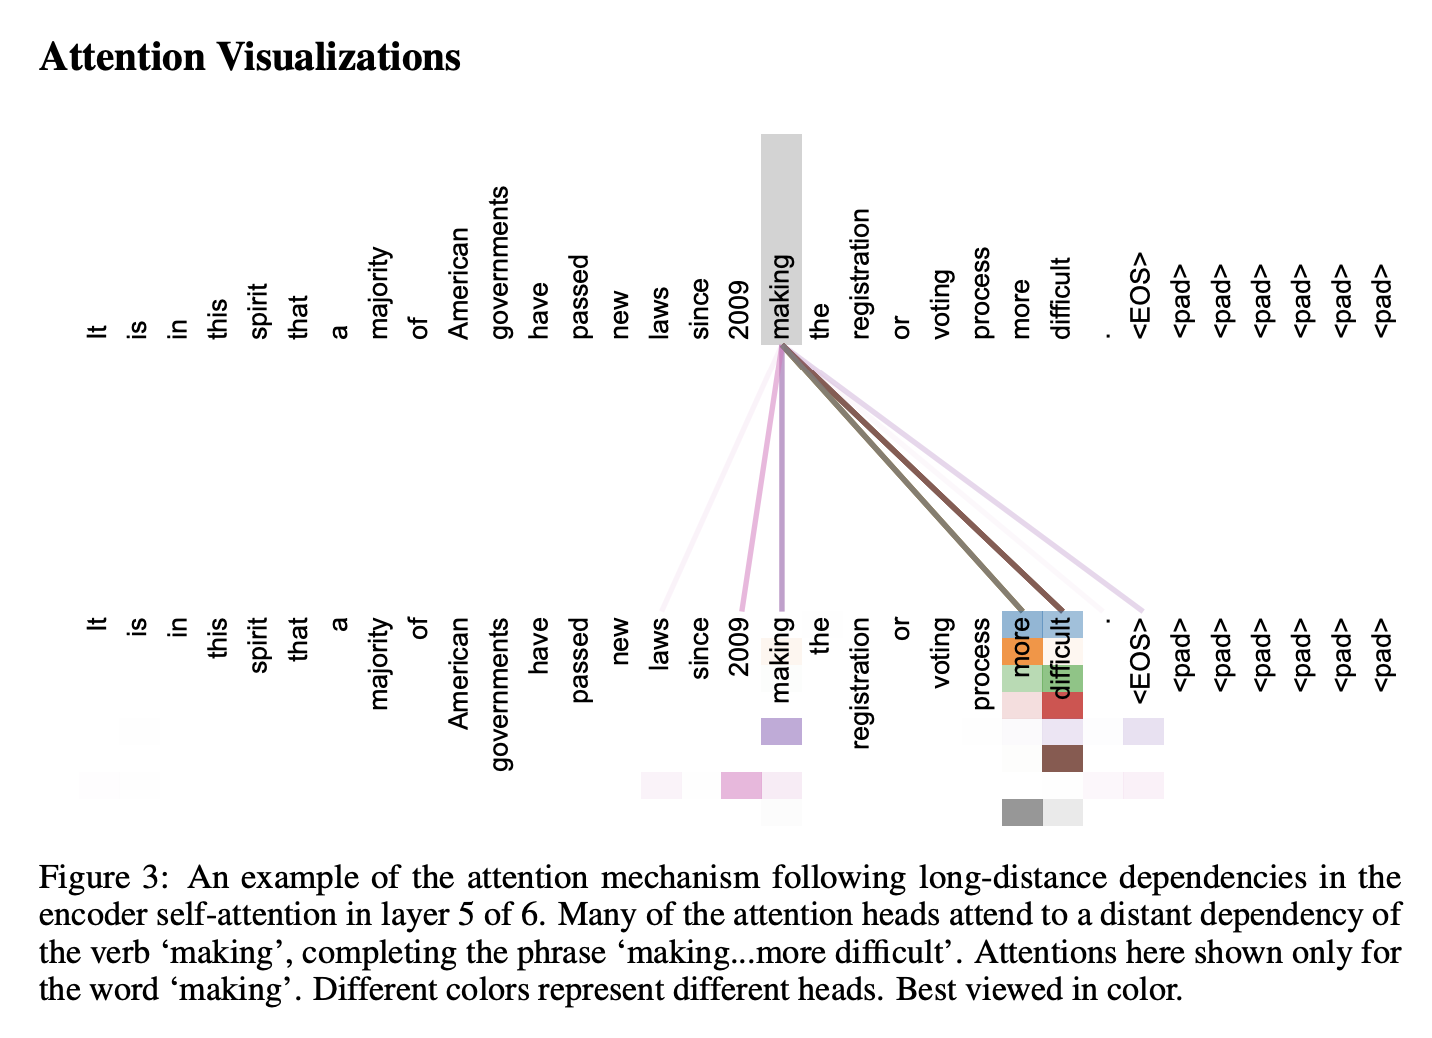

- We use the `<|endoftext|>` tokens between two independent sources of text:  
 `<|endoftext|>` 主要是让模型知道文本之间是不相关的。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="500px">

- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)  
为了处理上面报错的例子，我们可以把特殊的token `"<|unk|>"` 添加到词汇表中  
同时，仿照 GPT-2 把 `"<|endoftext|>"` 也添加进去，用来表示文本的结束，填充和连接。

In [19]:
#添加"<|endoftext|>", "<|unk|>"到新的词汇表
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [20]:
len(vocab.items())

1132

多了两个词，之前词典（vocab）的长度是1130，多出来的是 "<|endoftext|>", "<|unk|>"\

In [21]:
#展示扩展后的vocab中的token和token ID的对应
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new `<unk>` token  
调整 tokenizer，使得新的 tokenizer 知道什么时候用新的 token `<unk>`

In [22]:
#定义新的类SimpleTokenizerV2，能够把 vocab 中没有的词标记为 `<unk>`
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        #token 不在 vocab 中的时候用 "<|unk|>"
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Let's try to tokenize text with the modified tokenizer:  
现在用新的 tokenizer 来 tokenize 文本

In [23]:
#用新的 tokenizer
tokenizer = SimpleTokenizerV2(vocab)

#新的文本中包含 vocab 中没有的单词（"Hello"），以及文本间的连接（" <|endoftext|> "）
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [24]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [25]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

可以看到新的 tokenizer 工作的很好

## 2.5 BytePair encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer  
GPT-2 使用 BytePair encoding(BPE)作为其分词器(tokenizer)  

- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words  
BPE把单词拆分成更小的字词，或者词元，这样能够处理表外单词。也就是能处理没有在预先定义的词汇表中的单词。

- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges  
举例来说，如果 "unfamiliarword" 不在 GPT-2 的词汇表中，它可能会被分词为["unfam", "iliar", "word"]或其他子词组合，具体取决于BPE训练时学到的合并规则

- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)  
原始的 BPE 分词器代码链接  

- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance  
这个程序使用了 OpenAI 开源的 tiktoken 库中的 BPE 分词器，该库使用 Rust 实现核心算法以提高计算性能

- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)  
作者创建了一个比较这两种实现(原始 Python 版本和 tiktoken )的笔记本，发现在样本文本上tiktoken 大约快5倍

In [26]:
# pip install tiktoken

In [27]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


BPE 这个 tokenizer 使用方法和前面的 SimpleTokenizerV2 使用方法类似

In [28]:
#用 GPT-2 的 tiktoken 库的 BPE 做分词器（tokenizer）
tokenizer = tiktoken.get_encoding("gpt2")

In [29]:
#encoding
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
# allowed_special={"<|endoftext|>"} 参数指定允许处理的特殊标记。如果不指定这个参数，分词器可能会把 <|endoftext|> 当作普通文本处理。

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [30]:
[print(tokenizer.decode([i])) for i in integers]

Hello
,
 do
 you
 like
 tea
?
 
<|endoftext|>
 In
 the
 sun
lit
 terr
aces
of
 some
unknown
Place
.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

关于 BPE 分词器处理文本的两个关键特点：

1. **特殊标记位置**：`<|endoftext|>`标记被分配了较大的token ID(50256)。BPE分词器(用于GPT-2/3和原始ChatGPT模型)总词汇量为50,257个token，`<|endoftext|>`占用最大ID。

2. **处理未知词**：BPE分词器能正确编码和解码如"someunknownPlace"这样的未知词汇，无需使用`<|unk|>`标记。它通过将未知词分解为已知的子词单元或单个字符来实现这一功能，使模型能处理任何未见过的词汇。

In [31]:
#decoding
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


- BPE tokenizers break down unknown words into subwords and individual characters:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="300px">

本书没有详解BPE(字节对编码)的原理，但是可以简单了解下  

BPE(字节对编码)的工作原理简述：

1. **构建词汇表的迭代过程**：
   * 初始阶段：将所有单个字符添加到词汇表中("a", "b", ...)
   * 迭代合并：根据频率将常见的字符组合合并成子词
   * 例如："d"和"e"可能合并成子词"de"，因为它在英语单词如"define"、"depend"、"made"和"hidden"中频繁出现

2. **合并规则**：
   * 基于频率阈值决定哪些字符组合被合并
   * 通过统计分析语料库中的组合频率来确定合并优先级

这种方法使BPE能够将任何未知词分解为已知的子词单位，解决了词汇表外单词的处理问题，同时保持了词汇表的合理大小。

## 2.6 Data sampling with a sliding window

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

产生训练 LLM 需要的 输入-目标对（input-target pairs）（看下图）

本节实现一个数据加载器（data loader），该加载器使用滑动窗口方法从训练数据集中提取输入-目标对。

具体来说：

1. **数据加载器（data loader）**：
   - 这是一个程序组件，负责从数据集中读取数据并准备为模型训练所需的格式

2. **输入-目标对（input-target pairs）**：
   - 这是监督学习中的数据格式，其中"输入"是提供给模型的数据，"目标"是模型应该预测的数据（

3. **滑动窗口方法（sliding window approach）**：
   - 这是一种处理序列数据的技术
   - 在语言模型训练中，通常指在文本上"滑动"一个固定大小的窗口
   - 窗口内的前面部分作为输入，后面部分作为预测目标
   - 然后窗口向前移动一定步长，提取下一个输入-目标对

这种方法允许从连续文本中创建多个训练样本，最大化数据利用率，同时使模型学习预测序列中的下一个元素。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="400px">

In [33]:
#首先 tokenize 之前的 The Verdict short story 全文
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
#这里的 tokenizer 还是2.4中用的 BPE
enc_text = tokenizer.encode(raw_text)
#打印编码后的 token 序列长度
print(len(enc_text))

5145


BPE token 是 5145，回忆下之前直接分词的 token 数量是4690  
BPE的多是因为提取了词元

- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

从数据集中移除前50个 token （即标记或词元）。  
这是一个为了演示目的而进行的操作，移除这些 token 的原因是让后续步骤中的文本段落更有趣或更具代表性。可能因为数据集开头包含一些标题、元数据或不太有代表性的内容。

In [34]:
enc_sample = enc_text[50:]

为"下一个词预测任务"创建输入-目标对的一种简单直观方法：

创建两个变量：x和y
- x：包含输入 tokens
- y：包含目标 tokens，实际上就是将输入序列向右移动1位

这种方法的本质是让模型学习从上下文(x)预测下一个词(y)。通过将整个序列分别向右错开一位，可以轻松构建这种训练模式，使模型能够学习文本中的序列关系。

例如，如果原始 token 序列是[A,B,C,D,E]：
- 输入x会是：[A,B,C,D]
- 目标y会是：[B,C,D,E]

这样模型就会学习：
- 看到 A，预测 B
- 看到 A,B，预测 C
- 看到 A,B,C，预测 D
- 看到 A,B,C,D，预测 E

这是训练语言模型的基本技术之一。

In [35]:
#构建输入tokens x；输出tokens y
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [36]:
#输入输出数据举例
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


箭头(---->)左边的所有内容指的是大语言模型(LLM)将接收的输入，而箭头右边的token ID代表LLM应该预测的目标token ID。

In [37]:
#输入输出文本举例（就是token ID decode了）
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


为了更好的演示效果，这里是输入输出对的文本演示（实际上 LLM 接受和输出的应该是上一个框中的 token ID形式

现在，需要的输入-目标对（input-target pairs）就构建好了

- We will take care of the next-word prediction in a later chapter after we covered the attention mechanism  
- 我们将在介绍完注意力机制后的后续章节中处理下一个词的预测

- For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one  
- 现在，我们实现一个简单的数据加载器，它遍历输入数据集并返回输入和向后移动一位的目标

- Install and import PyTorch (see Appendix A for installation tips)

In [38]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu124


- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="500px">

- Create dataset and dataloader that extract chunks from the input text dataset

这个内容补充下（PyTorch Dataset classes）

If you are new to the structure of PyTorch Dataset classes, such as shown in listing 2.5, please read section A.6, Setting up efficient data loaders, in Appendix A, which explains the general structure and usage of PyTorch Dataset and DataLoader classes.

In [39]:
from torch.utils.data import Dataset, DataLoader

#定义数据集类 GPTDatasetV1，用于处理文本数据以训练GPT类型的语言模型。
class GPTDatasetV1(Dataset):

  #构造函数接收四个参数：
    #txt: 原始文本内容
    #tokenizer: 分词器对象，用于将文本转换为token ID
    #max_length: 每个训练序列的最大长度
    #stride: 滑动窗口的步长，控制序列之间的重叠程度
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []#初始化列表用于存储输入序列
        self.target_ids = []#初始化列表用于存储目标序列

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"
        #确保编码后的 token 数量足够多，至少比 max_length 长，否则无法创建有效的输入-目标对。

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride): #从索引0开始，以stride为步长遍历token序列
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        #对于每个位置i：
        #input_chunk取 i 到 i+max_length 的 token，长度为 max_length
        #target_chunk 取 i+1 到 i+max_length+1 的 token，也是长度为max_length
        #注意 target_chunk 比 input_chunk 向后偏移了1个位置

        #将切分的序列转换为 PyTorch 张量并存储

    def __len__(self):
      #返回数据集的大小（样本数量）。
        return len(self.input_ids)

    def __getitem__(self, idx):
      #获取指定索引的样本，返回一个元组：(输入序列, 目标序列)。
        return self.input_ids[idx], self.target_ids[idx]

In [40]:
#定义数据加载器，封装了从原始文本到训练数据加载器的完整过程
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
#函数接收的参数：

#txt: 原始文本数据，将被处理成训练样本
#batch_size=4: 每个批次包含的样本数量，默认为4
#max_length=256: 每个序列的最大长度（token数量），默认为256
#stride=128: 滑动窗口的步长，控制序列之间的重叠程度，默认为128
#shuffle=True: 是否在每个epoch随机打乱数据，默认为True
#drop_last=True: 如果最后一个批次的样本数小于batch_size，是否丢弃，默认为True
#num_workers=0: 用于数据加载的子进程数量，默认为0（不使用多进程）

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    #创建一个 PyTorch 的 DataLoader 对象，它负责从数据集中批量加载数据。
    dataloader = DataLoader(
        dataset,#前面创建的数据集对象
        batch_size=batch_size,#每次加载的样本数量
        shuffle=shuffle,#如果为True，每个epoch会随机打乱数据顺序，这有助于模型的泛化能力
        drop_last=drop_last,#如果为True，当样本数不能被batch_size整除时，会丢弃最后一个不完整的批次
        num_workers=num_workers#用于数据加载的子进程数量，提高加载效率
    )

    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:  
测试 dataloader， batch size 为1， context size 为4

In [41]:
#导入文本
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [42]:
#测试 dataloader
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)# 将数据加载器转换为一个迭代器，这样就可以逐批次访问数据
#iter() 是 Python 内置函数，用于将一个可迭代对象（iterable）转换为迭代器（iterator）。
#启用顺序访问：迭代器允许我们使用 next() 函数一次获取一个元素
#状态跟踪：迭代器会记住当前访问的位置，每次调用 next() 都会返回序列中的下一个元素

first_batch = next(data_iter)# 从迭代器中获取第一个批次的数据
print(first_batch)# 打印出这个批次的内容

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [43]:
#测试 dataloader
dataloader = create_dataloader_v1(
    raw_text, batch_size=2, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)# 将数据加载器转换为一个迭代器，这样就可以逐批次访问数据
#iter() 是 Python 内置函数，用于将一个可迭代对象（iterable）转换为迭代器（iterator）。
#启用顺序访问：迭代器允许我们使用 next() 函数一次获取一个元素
#状态跟踪：迭代器会记住当前访问的位置，每次调用 next() 都会返回序列中的下一个元素

first_batch = next(data_iter)# 从迭代器中获取第一个批次的数据
print(first_batch)# 打印出这个批次的内容

[tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]]), tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])]


In [44]:
#测试 dataloader
dataloader = create_dataloader_v1(
    raw_text, batch_size=3, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)# 将数据加载器转换为一个迭代器，这样就可以逐批次访问数据
#iter() 是 Python 内置函数，用于将一个可迭代对象（iterable）转换为迭代器（iterator）。
#启用顺序访问：迭代器允许我们使用 next() 函数一次获取一个元素
#状态跟踪：迭代器会记住当前访问的位置，每次调用 next() 都会返回序列中的下一个元素

first_batch = next(data_iter)# 从迭代器中获取第一个批次的数据
print(first_batch)# 打印出这个批次的内容

[tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]]), tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402]])]


In [45]:
#测试 dataloader
dataloader = create_dataloader_v1(
    raw_text, batch_size=2, max_length=4, stride=2, shuffle=False
)

data_iter = iter(dataloader)# 将数据加载器转换为一个迭代器，这样就可以逐批次访问数据
#iter() 是 Python 内置函数，用于将一个可迭代对象（iterable）转换为迭代器（iterator）。
#启用顺序访问：迭代器允许我们使用 next() 函数一次获取一个元素
#状态跟踪：迭代器会记住当前访问的位置，每次调用 next() 都会返回序列中的下一个元素

first_batch = next(data_iter)# 从迭代器中获取第一个批次的数据
print(first_batch)# 打印出这个批次的内容

[tensor([[  40,  367, 2885, 1464],
        [2885, 1464, 1807, 3619]]), tensor([[ 367, 2885, 1464, 1807],
        [1464, 1807, 3619,  402]])]


In [46]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 1807,  3619,   402,   271],
        [  402,   271, 10899,  2138]]), tensor([[ 3619,   402,   271, 10899],
        [  271, 10899,  2138,   257]])]


- An example using stride equal to the context length (here: 4) as shown below:

"stride equal to the context length" 的意思是步长（stride）的值等于上下文长度（context length）。在这个例子中，上下文长度是4，所以stride也设为4。
具体来说：

context length（上下文长度）是指每个输入序列的长度，即max_length参数的值，这里是4个token
stride（步长）是指滑动窗口每次移动的距离

当stride等于context length（这里都是4）时，意味着每次滑动窗口会完全移动到新的位置，不会有重叠部分。这相当于将文本切分成连续的、不重叠的块。
如果用数字表示，假设有一串token [0,1,2,3,4,5,6,7,8,9]：

第一个窗口：[0,1,2,3]
第二个窗口：[4,5,6,7]
第三个窗口：[8,9,...]（这个可能不完整）

相比之下，如果stride小于context length，那么窗口之间会有重叠：

stride=2，窗口长度=4时：[0,1,2,3], [2,3,4,5], [4,5,6,7], [6,7,8,9]

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="500px">

- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [47]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings

- The data is already almost ready for an LLM  
用于 LLM 的数据基本准备好了
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer  
最后来用嵌入层（embedding layer）把 tokens 嵌入为连续的向量
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training  
通常来说这种嵌入层是 LLM 本身的一部分并且会在模型训练时更新。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/15.webp" width="400px">

- Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [48]:
input_ids = torch.tensor([2, 3, 5, 1])

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [49]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [50]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


这里的权重矩阵初始值是随机的，后续会在 LLM 的训练中被优化。  
这个权重矩阵是 6 * 3，每一行对应一个词，每一列对应一个嵌入的维度。

- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in [./embedding_vs_matmul](../03_bonus_embedding-vs-matmul)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 3 into a 3-dimensional vector, we do the following:  
-将id为3的 token 转换为三维向量，我们执行以下操作：

In [51]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 4th row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [52]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:  
嵌入层本质上是一个查找操作：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="500px">

- **You may be interested in the bonus content comparing embedding layers with regular linear layers: [../03_bonus_embedding-vs-matmul](../03_bonus_embedding-vs-matmul)**

## 2.8 Encoding word positions

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:  

- 嵌入层将 ID 转换为相同的向量表示，不考虑它们在输入序列中的位置。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="400px">

可以看出这里面的 fox 虽然是不同的位置，但是 embedding vectors 是完全一样的

- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:  
结合位置嵌入和词元嵌入，来形成 LLM 的输入嵌入

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="500px">

位置嵌入主要有两大类别：相对位置嵌入和绝对位置嵌入。



*  绝对位置嵌入直接与序列中的特定位置相关联。对于输入序列中的每个位置，都会为token 的嵌入添加一个独特的嵌入，以表示其确切位置。例如，第一个token有特定的位置嵌入，第二个token有另一个不同的嵌入，依此类推，如上图所示。
*   相对位置嵌入则不关注token的绝对位置，而是强调token之间的相对位置或距离。这意味着模型学习的是"相距多远"而非"在哪个确切位置"的关系。这种方法的优势在于模型能更好地泛化到不同长度的序列，即使在训练过程中没有见过这些长度的序列。

- The BytePair encoder has a vocabulary size of 50,257:  
BPE 的词汇表大小是50257  
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:  
假设我们想把编码输出词元编码成256维的向量表示。

In [53]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector  
-如果我们从dataloader采样数据，我们将每个批中的词元嵌入到一个256维的向量中

- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:  
-如果我们有一个批次大小为8，每个批次有4个词元，这将得到一个8 x 4 x 256张量：

In [54]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [55]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [56]:
#把每个 token 嵌入成256维的向量
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [57]:
print(token_embeddings)

tensor([[[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
         [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
         [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
         [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],

        [[ 1.5460,  1.7368, -0.7848,  ..., -0.1004,  0.8584, -0.3421],
         [-1.8622, -0.1914, -0.3812,  ...,  1.1220, -0.3496,  0.6091],
         [ 1.9847, -0.6483, -0.1415,  ..., -0.3841, -0.9355,  1.4478],
         [ 0.9647,  1.2974, -1.6207,  ...,  1.1463,  1.5797,  0.3969]],

        [[-0.7713,  0.6572,  0.1663,  ..., -0.8044,  0.0542,  0.7426],
         [ 0.8046,  0.5047,  1.2922,  ...,  1.4648,  0.4097,  0.3205],
         [ 0.0795, -1.7636,  0.5750,  ...,  2.1823,  1.8231, -0.3635],
         [ 0.4267, -0.0647,  0.5686,  ..., -0.5209,  1.3065,  0.8473]],

        ...,

        [[-1.6156,  0.9610, -2.6437,  ..., -0.9645,  1.0888,  1.6383],
         [-0.3985, -0.9235, -1.3163,  ..., -1.1582, -1.13

- GPT-2 uses absolute position embeddings, so we just create another embedding layer:  
GPT-2 模型使用绝对位置嵌入（absolute position embeddings）来处理序列中单词的位置信息。这些嵌入在训练过程中进行优化，而非像原始 Transformer 模型中那样使用固定或预定义的位置编码。  

Transformer 中的位置编码是通过正弦和余弦函数算出来的，每个位置有一个固定的编码，并不改变。它的好处是对于更长的序列有一定的泛化性，因为这个位置编码的算法是有规律的。  

而 GPT-2 位置编码是指定一个随机矩阵，然后通过模型迭代学习这个位置编码的表示。

对于GPT模型的绝对嵌入方法，我们只需创建另一个与 token_embedding_layer 具有相同维度的嵌入层：

In [58]:
# output_dim 是256
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
print(pos_embedding_layer.weight)

Parameter containing:
tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       requires_grad=True)


In [59]:
print(pos_embedding_layer.weight.shape)

torch.Size([4, 256])


In [60]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [61]:
print(pos_embeddings)

tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [62]:
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [63]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


当执行 input_embeddings = token_embeddings + pos_embeddings 时，PyTorch 会自动进行广播(broadcasting)操作。广播是一种允许形状不同的张量进行运算的机制。  
在这种情况下：

token_embeddings 的形状是 [8, 4, 256]  
pos_embeddings 的形状是 [4, 256]

广播会自动将 pos_embeddings 扩展为 [1, 4, 256]，然后再扩展为 [8, 4, 256]，使其与 token_embeddings 形状匹配。这样就可以直接进行元素级加法操作。

In [64]:
print(input_embeddings)

tensor([[[ 2.2288,  0.5619,  0.8286,  ..., -0.6272, -0.2987,  0.8900],
         [ 2.0903, -0.4664, -0.0593,  ...,  0.9115, -1.0493, -1.6473],
         [-0.7158, -0.8304,  1.2494,  ...,  2.3952,  1.8773,  0.8051],
         [ 0.2703,  0.4029,  3.0514,  ...,  0.3595, -1.4548,  0.8310]],

        [[ 3.2835,  1.1749, -1.4150,  ..., -0.3281,  2.4332,  0.6924],
         [-0.2199, -0.9114, -0.1750,  ...,  1.5337, -0.1998,  0.1462],
         [ 1.5197, -1.4240,  0.4391,  ...,  1.0494, -1.4318,  2.3057],
         [ 0.2893,  0.8346, -0.1884,  ...,  1.9602,  0.8709,  0.8796]],

        [[ 0.9662,  0.0952, -0.4640,  ..., -1.0320,  1.6290,  1.7771],
         [ 2.4468, -0.2154,  1.4984,  ...,  1.8766,  0.5595, -0.1423],
         [-0.3856, -2.5393,  1.1556,  ...,  3.6157,  1.3267,  0.4944],
         [-0.2487, -0.5275,  2.0009,  ...,  0.2930,  0.5977,  1.3300]],

        ...,

        [[ 0.1219,  0.3991, -3.2740,  ..., -1.1921,  2.6637,  2.6728],
         [ 1.2438, -1.6436, -1.1101,  ..., -0.7464, -0.98

- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="400px">

# Summary and takeaways

See the [./dataloader.ipynb](./dataloader.ipynb) code notebook, which is a concise version of the data loader that we implemented in this chapter and will need for training the GPT model in upcoming chapters.

See [./exercise-solutions.ipynb](./exercise-solutions.ipynb) for the exercise solutions.

See the [Byte Pair Encoding (BPE) Tokenizer From Scratch](../02_bonus_bytepair-encoder/compare-bpe-tiktoken.ipynb) notebook if you are interested in learning how the GPT-2 tokenizer can be implemented and trained from scratch.